# Authors:
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# 1. Initial setup


---


First we will configure the environment to have the necessary library dependencies loaded, the dataset (via Google Drive mount) and finally make sure that the GPU of the environment is available. Note that although RNNs are not very parallelizable, tensor operations with GPU increase the computational speed.

### Imports

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras import utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt

### Load DS Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/Inteligencia Artificial/Teoría/Q2.2/Aprendizaje Profundo/Prácticas/P2/'
folder = '/content/drive/MyDrive/amazon/'
ds_file_name_path = (folder + 'train_small.txt', folder + 'test_small.txt')

Mounted at /content/drive


### Set gpu

In [ ]:
def setup_gpu():
  device_name = tf.test.gpu_device_name()
  if device_name == '/device:GPU:0':
    tf.device(device_name)
    print("GPU DETECTED")

setup_gpu()

# 2. Load dataset


---


Next, the dataset located in `ds_file_name_path` (tuple with train and validation files paths) will be loaded. The text files are in a specific format so that the first line of each review indicates whether it is positive or negative (__label__1 or __label__2). 

The function in charge of reading the dataset, splitting the samples and loading the labels will be `readData` (which will also return the average sequence length plus twice its standard deviation to estimate the sequence lengths). With the data loaded and divided by samples, the `transformData` function will tokenize the dataset transforming it into a format usable with neural models. Finally, the corresponding batched datasets grouping inputs and labels are created.

In [ ]:
"""
Reads the Amazon dataset and generates a train and test dataset

DS Format:
    label text \n

Returns:
    x: list of strings
    y: list of labels (0/1)
    seqLength: average length of the text + 2*std
"""
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):     
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(aLine.removeprefix("__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(aLine.removeprefix("__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))


"""
Transforms the text data to int data based on the vocabulary

max_tokens = maxFeatures is the size of the vocabulary
output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
"""
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    # Build the tokenizer
    precLayer = layers.experimental.preprocessing.TextVectorization(
        max_tokens = maxFeatures, 
        standardize =  'lower_and_strip_punctuation', 
        split = 'whitespace', 
        output_mode = 'int', 
        output_sequence_length =  seqLength
    )
    # Fit the tokenizer to the training data
    precLayer.adapt(x_train)
    print("Vocabulary size: ", len(precLayer.get_vocabulary()))
    # Tokenize the training and test data
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [ ]:
x_train, y_train, seqLength = readData(ds_file_name_path[0])
x_test, y_test, _ = readData(ds_file_name_path[1])

#maxFeatures is a hyperparameter
maxFeatures = 20000 # 71086 is amount of tokens in the training set

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength)
print(f"{seqLength = }")
print(f"{x_train_int.shape = }")
print(f"{y_train.shape = }")
print(f"{x_test_int.shape = }")
print(f"{y_test.shape = }")
print(f"{x_train_int.dtype = }")
print(f"{y_train.dtype = }")

Vocabulary size:  20000
seqLength = 166
x_train_int.shape = TensorShape([25000, 166])
y_train.shape = TensorShape([25000])
x_test_int.shape = TensorShape([25000, 166])
y_test.shape = TensorShape([25000])
x_train_int.dtype = tf.int64
y_train.dtype = tf.int32


In [ ]:
# Create batched dataset
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train_int,y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_int,y_test)).batch(batch_size)

# 3. Train and evaluate the model


---


In this section the training process will be defined and different experiments with multiple networks and recurrent architectures will be performed. Note that recurrent networks will be used because of their ability by design to handle data sequences. Specifically, three types of recurrent networks will be considered:

- Recurrent Neural Network (RNN): it is the most basic type of recurrent networks, containing links between the previous predictions and the current prediction. This link is what makes it suitable to model temporal data, since the previous information is used to predict the next output.

- Long-Short Term Memory (LSTM): it aims to solving the problem by design of the RNNs in which the information from a specific timestep vanishes as the time passes by due to the gradient calculation over time (new activations overwrite activations from previous cells). Therefore, it is told to provide long-term memory to the network. It is designed with a series of gates that selectively choose the information from the past to be kept and the one to be forgotten.

- Gated Reccurent Unit (GRU): it can be seen as a simpler LSTM. It also contains gates to select the information but using less operations. Because of this, they are faster and consume less memory than a LSTM.


Additionally, note the parameterization allowed by the `create_model` function.

In [ ]:
def create_model(recurrent_unit=layers.LSTM, embedding_size=64, cell_units=[64,64], dropout=(0.,0.,0.), hidden_layer=None, regularization=(0,0), bidirectional=True):
  # Input
  inputs = keras.Input(shape=(seqLength))

  # Embedding
  x = layers.Embedding(maxFeatures, embedding_size, input_length=seqLength, mask_zero=True)(inputs) # 0 padding -> mask_zero

  # Recurrent layers
  lstm_dropout, recurrent_dropuot, dense_dropout = dropout
  for i, units in enumerate(cell_units):
      recurrent_cell = recurrent_unit(units, return_sequences=len(cell_units[i:]) != 1, recurrent_dropout=recurrent_dropuot, dropout=lstm_dropout, kernel_regularizer=regularizers.L1L2(l1=regularization[0], l2=regularization[1]))
      if bidirectional:
        recurrent_cell = layers.Bidirectional(recurrent_cell)
      x = recurrent_cell(x)

  # Dense dropout 
  if dense_dropout != 0.:
    x = layers.Dropout(dense_dropout)(x)

  # Output    
  if hidden_layer is not None:
    x = layers.Dense(hidden_layer)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  # Return
  model = keras.Model(inputs=inputs, outputs=outputs, name="amazon_review")
  model.summary()
  return model
  

def train_model(model, ds_train_batch, ds_test_batch, epochs=20, lr=0.001, optimizer=optimizers.Adam, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy"])

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(ds_train_batch, epochs=epochs, validation_data=ds_test_batch, callbacks=callbacks)
  return history


def plot_results(history):

  history = history.history
  loss, val_loss = history['loss'], history['val_loss']
  accuracy, val_accuracy = history['accuracy'], history['val_accuracy']

  epochs = range(1, len(history['loss']) + 1)
  fig, axs = plt.subplots(1, 2, figsize=(9,4))
  for idx, measure in enumerate(["loss", "accuracy"]):
    axs[idx].plot(epochs, eval(measure), 'b-o', label=f'Training {measure}')
    axs[idx].plot(epochs, eval(f"val_{measure}"), 'r-o', label=f'Validation {measure}')
    axs[idx].set_title(f'Training and validation {measure}')
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel(measure.capitalize())
    axs[idx].legend()

  plt.tight_layout()
  plt.show()


def execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, seed=1):

  # Set the seed to ensure reproducibility
  utils.tf_utils.set_random_seed(seed)  
  random.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)

  model = create_model(recurrent_unit=hyperparameters["recurrent_unit"], cell_units=hyperparameters["cell_units"], dropout=hyperparameters["dropout"], hidden_layer=hyperparameters["hidden_layer"], embedding_size=hyperparameters["embedding_size"], regularization=hyperparameters["regularization"])
  history = train_model(model, ds_train_batch, ds_test_batch, hyperparameters["epochs"], 
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot_results(history)

  return model, history

## Optimal Architecture search - non overfitting mitigation

First, the complexity of the problem to be solved must be estimated by trial and error. That is, creating, training and analyzing different networks from the simplest to the most complex.

For this first contact, in the first executions a dictionary size of 2000 will be used, as well as the sequence size suggested by the function that loads the dataset (`mean_seq_len + 2*std_seq_len`).

In these first runs, models with a single recurrent cell will be tested incrementally, seeking to find the most complex model that can be adapted to the problem (maximum validation metrics). After this, the same will be done for models with 2 nested recurrent units. As we have already mentioned, the architectures used will be RNNs due to their simplicity, LSTM due to their ability to store long-term dependencies between words so they should improve the results over RNNs, and GRUs due to the fact that they are designed with the same goal as LSTMs but they are simpler and, a priori, more efficient.

After observing the behavior in this really simple networks, we will start testing different variations, focusing on what gives the best results. It should be noted that if a modification by itself does not provide a performance improvement, it will be discarded or another configuration will be tested, being able to add or not the different elements to be tested.

As will be discussed in the results section, only networks with a maximum of 2 nested recurrent units have been used and no recurrent cell consists of more than 128 neurons, being these quantities more than enough for the problem to be solved.

As for changes to be made after the first executions, it is worth mentioning the change in the size of the lexicon as well as the change of optimizer. 

Finally, note that the only mitigation method for overtraining will be the **Early Stopping**, especially interesting to avoid unnecessary computations and to stop training when the model stops learning. Thus, the objective (and the most important figure) will be to analyze the evolution of the accuracy in precision. Therefore, to obtain the best version of the model, the control points at the end of each epoch should be used.

### One recurrent layer

Now, we will present the experiments regarding the architectures with just one single recurrent layer. In the following cells we will provide a brief conclusion of each sub-experiment. In general, we have observed that GRU is the best architecture, being able to handle better the complexity (increasing number of neurons) than the rest. Specially, the GRU with 64 neurons was the best one with an accuracy of 0.8875, even better than the GRU with 128 neurons. LSTMs models lie slightly behind GRUs with ~0.01 less of accuracy. However, we can observe that the training curves of GRUs are also a little bit smoother than LSTMs. In the case of RNNs, they were not able to reach the 0.85 of accuracy, and for a lot of neurons the curves start to zig-zag a lot, so they are clearly the worst model for this problem. For all of them, the overfitting appears very early, around epoch 5, although complex GRUs seem to learn a little bit faster and overfit since epoch 3.

#### single rnn (16) 
- Best result in validation: GRU, 0.8800
- Rapid achievement of high accuracies, then overfitting


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 16)           32000     
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 34,129
Trainable params: 34,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 66s 73ms/step - loss: 0.5256 - accuracy: 0.7509 - val_loss: 0.4052 - val_accuracy: 0.8272
Epoch 2/50
782/782 [=================

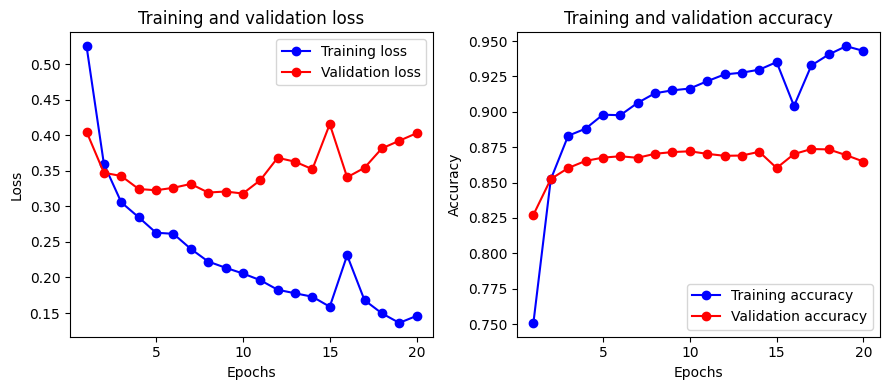

(<keras.engine.functional.Functional at 0x7efd8c71d070>,
 <keras.callbacks.History at 0x7efd003b7520>)

In [ ]:
# LSTM 16
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [16],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 16,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 16)           32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,545
Trainable params: 32,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 259s 329ms/step - loss: 0.6453 - accuracy: 0.6235 - val_loss: 0.5530 - val_accuracy: 0.7363
Epoch 2/50
782/782 [===============

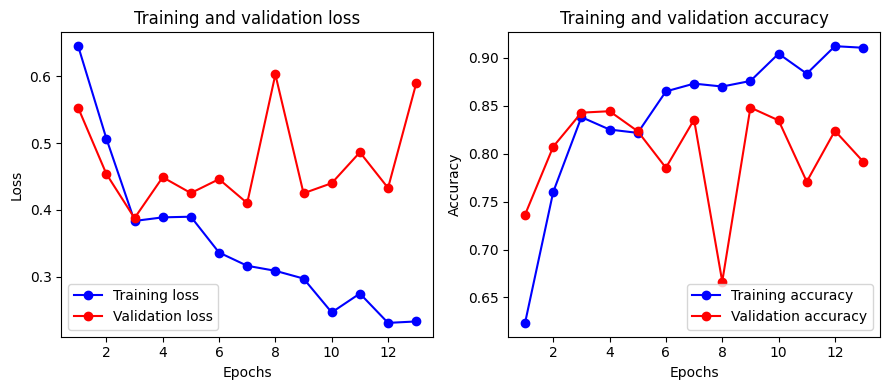

(<keras.engine.functional.Functional at 0x7efd0140e6a0>,
 <keras.callbacks.History at 0x7efd013c2340>)

In [ ]:
# SImple RNN 16
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 16)           32000     
                                                                 
 gru (GRU)                   (None, 16)                1632      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33,649
Trainable params: 33,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 50s 58ms/step - loss: 0.5032 - accuracy: 0.7416 - val_loss: 0.3708 - val_accuracy: 0.8452
Epoch 2/50
782/782 [=================

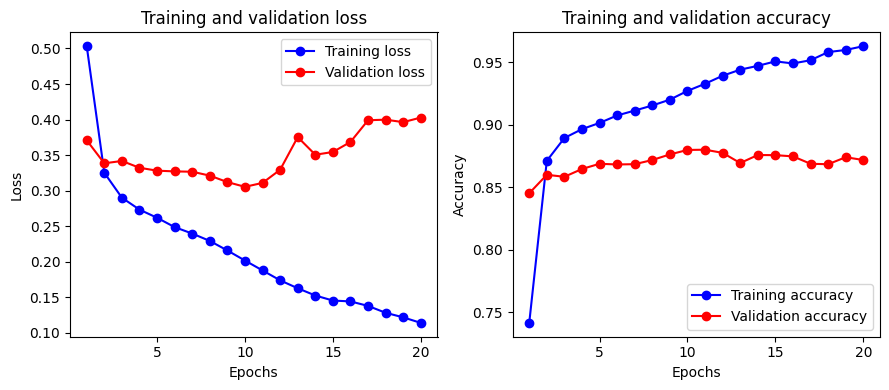

(<keras.engine.functional.Functional at 0x7efe077d4820>,
 <keras.callbacks.History at 0x7efd00c6b8b0>)

In [ ]:
# GRU 16
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

#### single rnn (32) 
- Best result in validation: GRU, 0.8852
- Rapid achievement of high accuracies, then overfitting

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 32)           64000     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 72,353
Trainable params: 72,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 64s 74ms/step - loss: 0.4608 - accuracy: 0.7833 - val_loss: 0.3610 - val_accuracy: 0.8518
Epoch 2/50
782/782 [=================

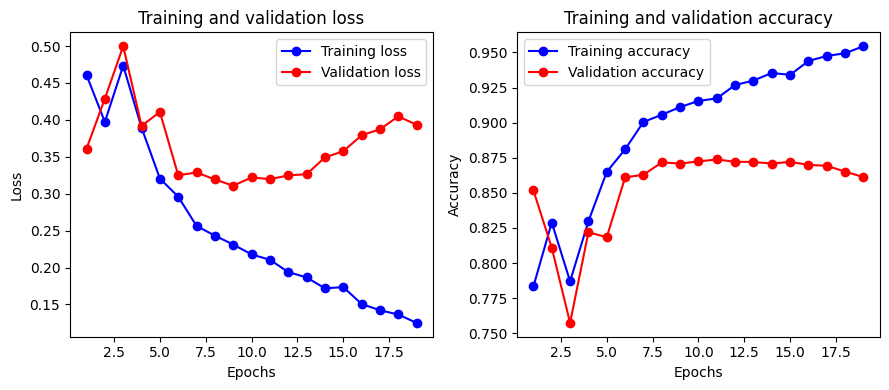

(<keras.engine.functional.Functional at 0x7efd8c3640a0>,
 <keras.callbacks.History at 0x7efd00d5dfd0>)

In [ ]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 66,113
Trainable params: 66,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 271s 332ms/step - loss: 0.6302 - accuracy: 0.6530 - val_loss: 0.5859 - val_accuracy: 0.7048
Epoch 2/50
782/782 [===============

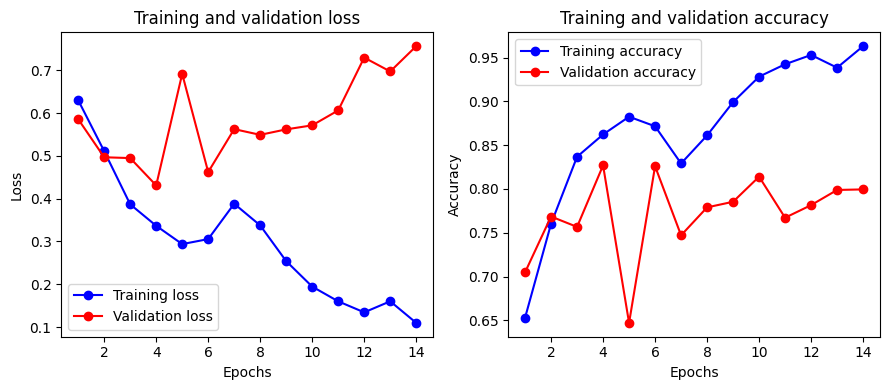

(<keras.engine.functional.Functional at 0x7fd9b2c7b460>,
 <keras.callbacks.History at 0x7fda300798b0>)

In [ ]:
# RNN 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 32)           64000     
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 70,369
Trainable params: 70,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 52s 58ms/step - loss: 0.4799 - accuracy: 0.7600 - val_loss: 0.3700 - val_accuracy: 0.8352
Epoch 2/50
782/782 [=================

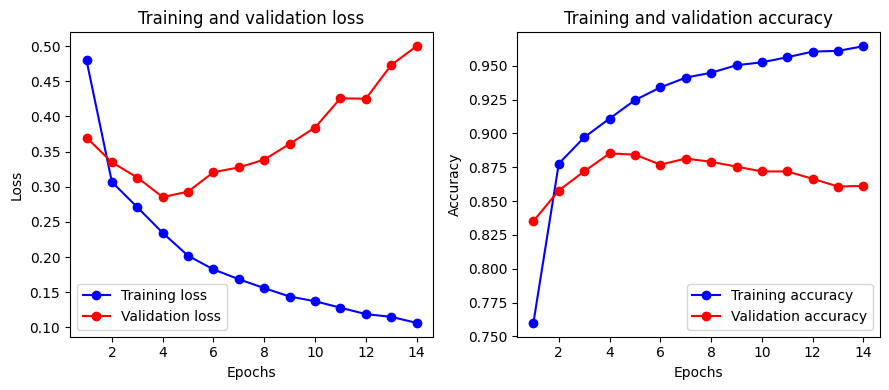

(<keras.engine.functional.Functional at 0x7fd99be6d9a0>,
 <keras.callbacks.History at 0x7fd99bf3ca90>)

In [ ]:
# GRU 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

#### single rnn (64)
- Best result in validation: GRU, 0.8875
- Rapid achievement of high accuracies (3º epoch), then overfitting


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           64000     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 77s 84ms/step - loss: 0.4554 - accuracy: 0.7860 - val_loss: 0.4876 - val_accuracy: 0.7709
Epoch 2/50
782/782 [=================

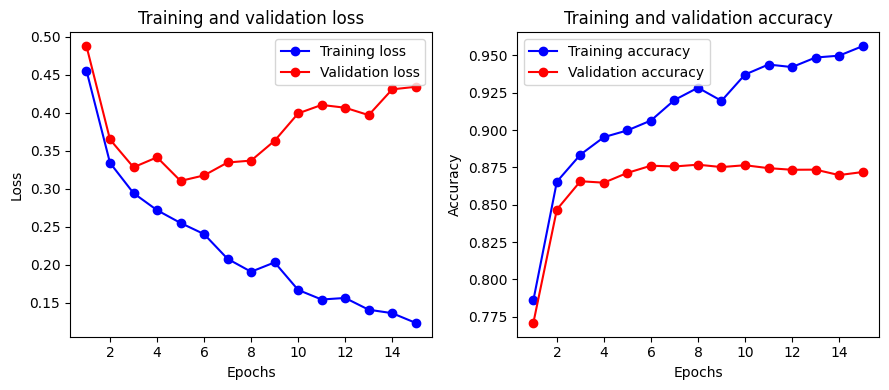

(<keras.engine.functional.Functional at 0x7f5fa5370d60>,
 <keras.callbacks.History at 0x7f5e828512e0>)

In [ ]:
# LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 32)           64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 249s 316ms/step - loss: 0.6283 - accuracy: 0.6417 - val_loss: 0.6228 - val_accuracy: 0.6578
Epoch 2/50
782/782 [===============

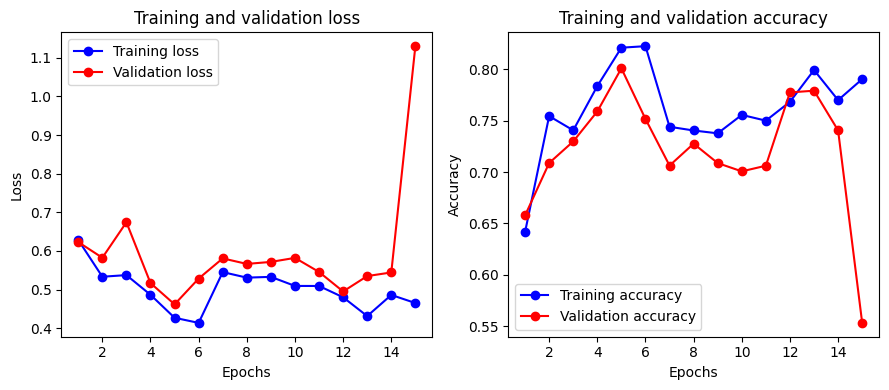

(<keras.engine.functional.Functional at 0x7f5e828fd640>,
 <keras.callbacks.History at 0x7f5e893a3940>)

In [ ]:
# RNN 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 32)           64000     
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 82,881
Trainable params: 82,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 50s 59ms/step - loss: 0.4849 - accuracy: 0.7633 - val_loss: 0.3653 - val_accuracy: 0.8479
Epoch 2/50
782/782 [=================

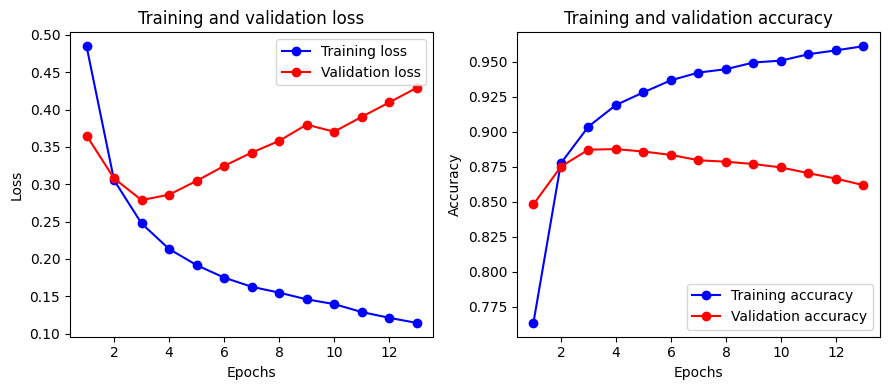

(<keras.engine.functional.Functional at 0x7f5e8b5dd250>,
 <keras.callbacks.History at 0x7f5e8b753fd0>)

In [ ]:
# GRU 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

#### single rnn (128)
- Without improvements
- The network with the optimal complexity is the one above (64 neurons)



Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 16)           32000     
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 106,369
Trainable params: 106,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 325s 408ms/step - loss: 0.4766 - accuracy: 0.7734 - val_loss: 0.4754 - val_accuracy: 0.7822
Epoch 2/50
782/782 [=============

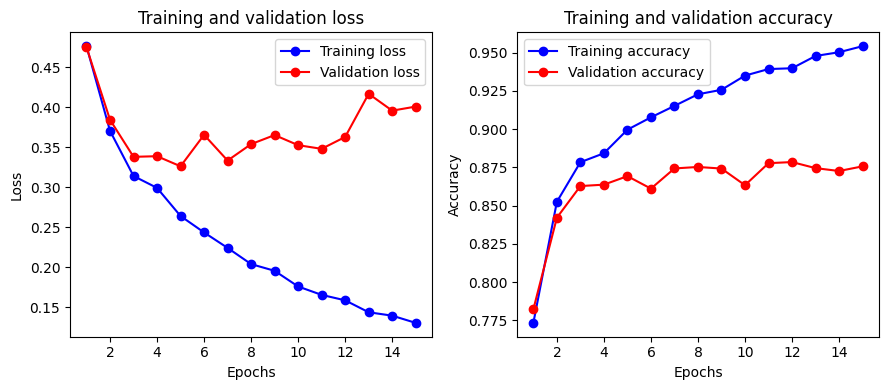

(<keras.engine.functional.Functional at 0x7fb1e322d910>,
 <keras.callbacks.History at 0x7fb1e3067430>)

In [ ]:
# LSTM 128
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 16,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 16)           32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               18560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,689
Trainable params: 50,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 102s 129ms/step - loss: 0.6980 - accuracy: 0.5094 - val_loss: 0.6999 - val_accuracy: 0.5052
Epoch 2/50
782/782 [===============

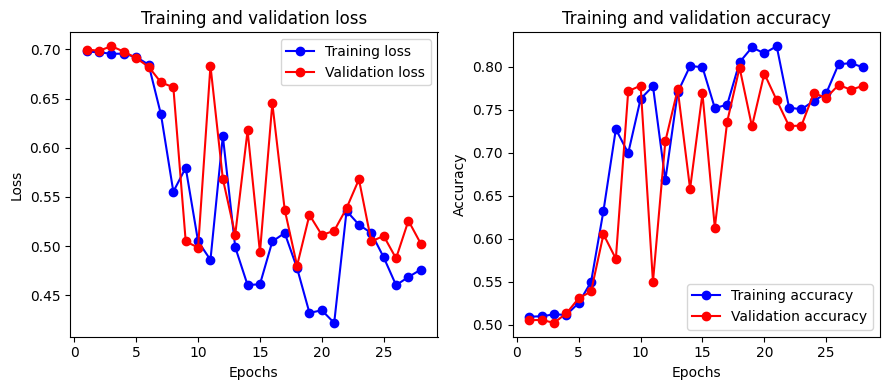

(<keras.engine.functional.Functional at 0x7fb1e0e07370>,
 <keras.callbacks.History at 0x7fb1d9fd4970>)

In [ ]:
# SImple RNN 128
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 16)           32000     
                                                                 
 gru (GRU)                   (None, 128)               56064     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 221s 275ms/step - loss: 0.5435 - accuracy: 0.7138 - val_loss: 0.4467 - val_accuracy: 0.8015
Epoch 2/50
782/782 [===============

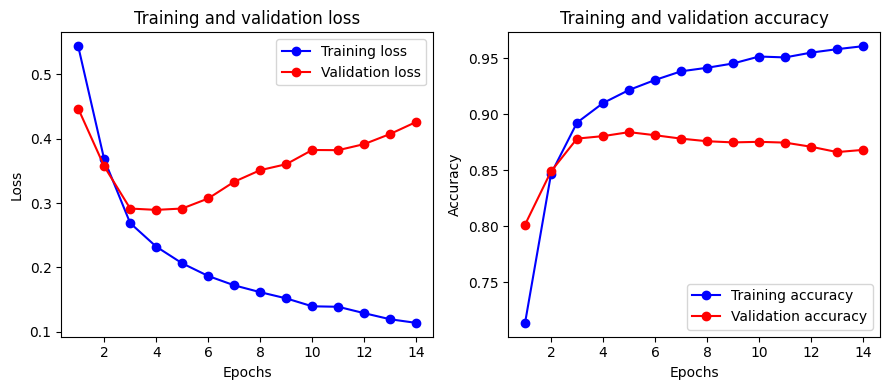

(<keras.engine.functional.Functional at 0x7fb1e09ab9a0>,
 <keras.callbacks.History at 0x7fb1e08f4910>)

In [ ]:
# GRU 128
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

### Two stacked recurrent layers

Now, we will try architectures with 2 stacked recurrent layers to check if we can model better the problem by adding a new layer on the top. 

Overall, we have not been able to improve the results. Some interesting insights are that GRUs are more stable and the overfitting is slightly reduced with 2 recurrent layers. This can be observe from the curves, since this time the accuracy curve in validation is flatter than in the previous experiment so, although the training accuracy is still improving, at least the accuracy in validation does not drop that much. For RNNs the zig-zag is still visible and for LSTMs the change is not appreciable.

#### 2 stacked recurrent layers (8,8)

- Without improvement
- May need a larger number of neurons to cope with the complexity of the problem

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 16)           32000     
                                                                 
 lstm (LSTM)                 (None, 166, 8)            800       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 33,353
Trainable params: 33,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=============================

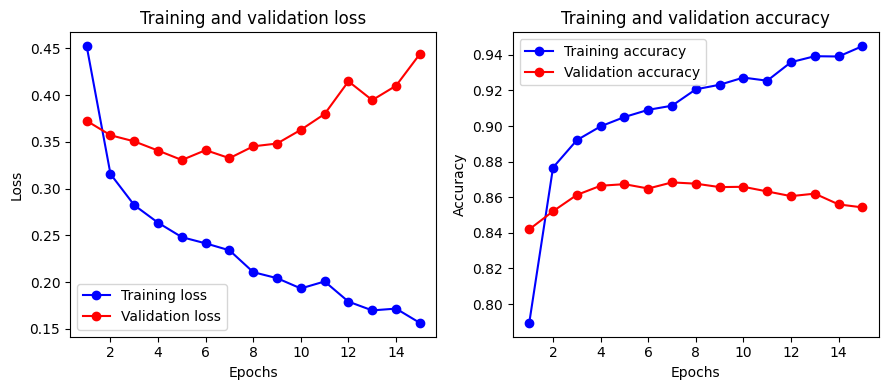

(<keras.engine.functional.Functional at 0x7fad5813b1f0>,
 <keras.callbacks.History at 0x7fad4dff1c70>)

In [ ]:
# LSTM 8 and 8
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [8,8],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 16,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 16)           32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 166, 8)            200       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,345
Trainable params: 32,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=============================

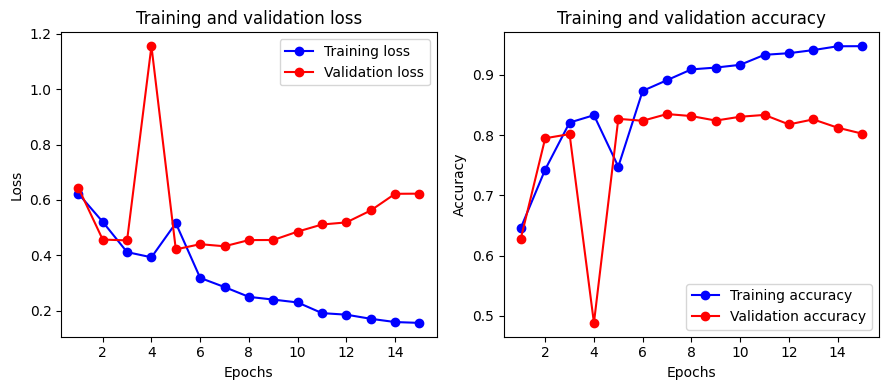

(<keras.engine.functional.Functional at 0x7fad68681430>,
 <keras.callbacks.History at 0x7fad6863a070>)

In [ ]:
# RNN 8 and 8
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 16)           32000     
                                                                 
 gru (GRU)                   (None, 166, 8)            624       
                                                                 
 gru_1 (GRU)                 (None, 8)                 432       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 33,065
Trainable params: 33,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=============================

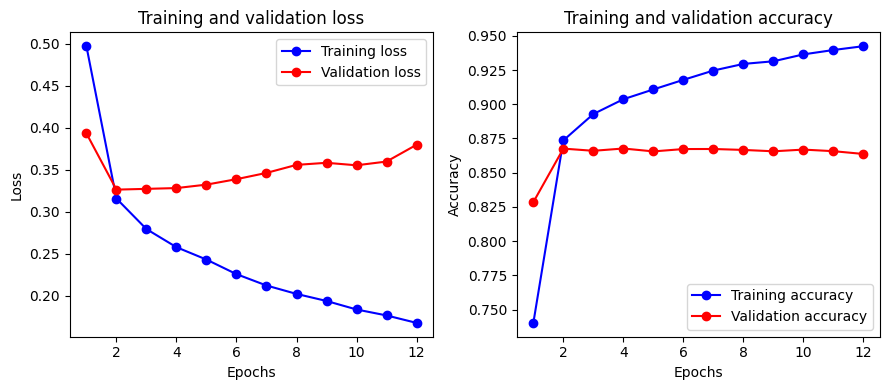

(<keras.engine.functional.Functional at 0x7fa1beef0850>,
 <keras.callbacks.History at 0x7fa1becb8d30>)

In [ ]:
# GRU 8 and 8
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

#### 2 stacked recurrent layers (32,32)
- Without improvement
- Overfitting but better stability


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 16)           32000     
                                                                 
 lstm_1 (LSTM)               (None, 166, 32)           6272      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,625
Trainable params: 46,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=============================

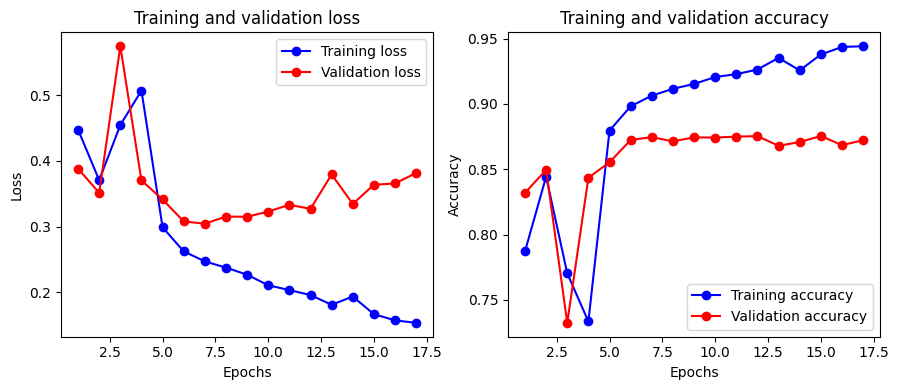

(<keras.engine.functional.Functional at 0x7f5e8b7bcfd0>,
 <keras.callbacks.History at 0x7f5e83220e20>)

In [ ]:
# LSTM 32 and 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 16,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 16)           32000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               18560     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,689
Trainable params: 50,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 101s 127ms/step - loss: 0.6980 - accuracy: 0.5094 - val_loss: 0.6999 - val_accuracy: 0.5052
Epoch 2/50
782/782 [===============

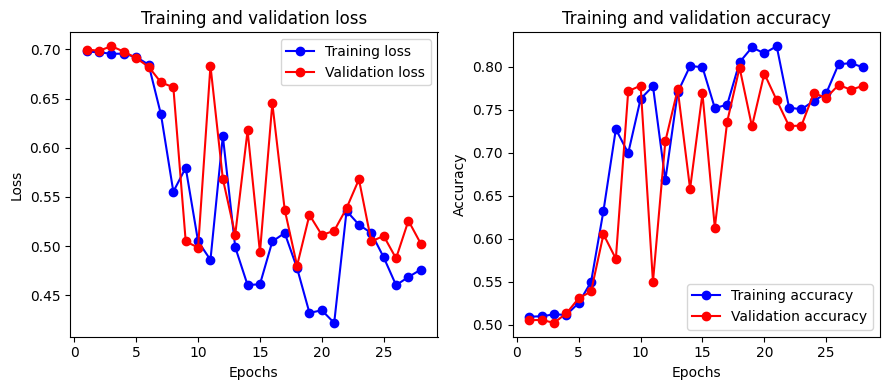

(<keras.engine.functional.Functional at 0x7fb1d860cbe0>,
 <keras.callbacks.History at 0x7fb1e44d55b0>)

In [ ]:
# RNN 32 and 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 166, 16)           32000     
                                                                 
 gru_1 (GRU)                 (None, 128)               56064     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 220s 274ms/step - loss: 0.5435 - accuracy: 0.7138 - val_loss: 0.4467 - val_accuracy: 0.8015
Epoch 2/50
782/782 [===============

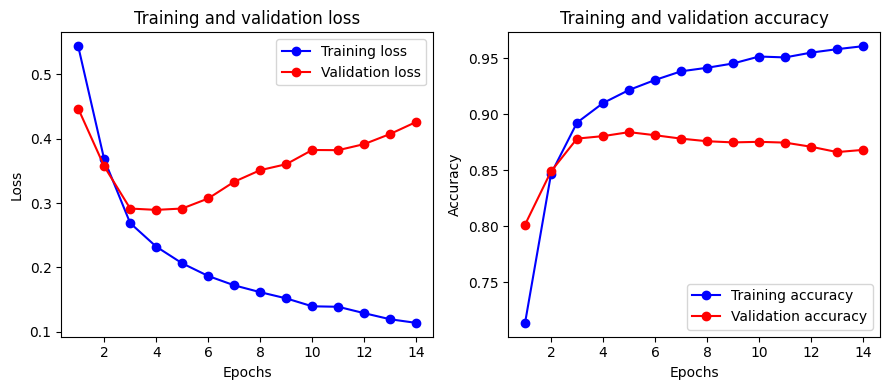

(<keras.engine.functional.Functional at 0x7fb1da5bf130>,
 <keras.callbacks.History at 0x7fb1da3470a0>)

In [ ]:
# GRU 32 and 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(train_ds, test_ds, hyperparameters)

### Different embedding size

Having checked that GRU is the best model in terms of accuracy, and it is able to deal with the architecture complexity much better than the others, we will proceed the next experiments with only this architecture.

The embedding size could impact significantly in text-related tasks, since it is the part of the model in charge of translating the word to a real-valued  representation to the following layers. Larger embedding size could allow the model to learn more words, but the training would be more difficult. Smaller embeddings are easier to train but their representational capabilities are limited.

In this case, changing the embedding size did not lead to an accuracy improvement in validation and the network still overfits, but we can observe that the number of epochs the network starts to overfit is delayed to epoch 8 (from the previous epoch 5)

Note that a similar experiment to this one will be performed in future runs, but with the lexicon size increased.

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 64)           128000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 161,089
Trainable params: 161,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 166s 207ms/step - loss: 0.5080 - accuracy: 0.7560 - val_loss: 0.4291 - val_accuracy: 0.7927
Epoch 2/50
782/782 [=============

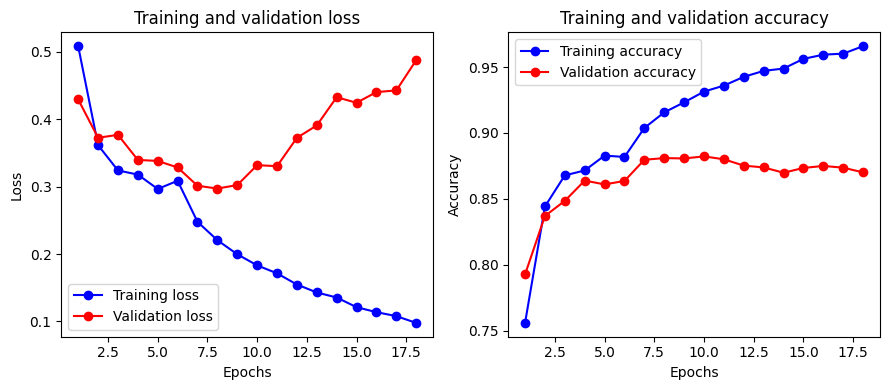

(<keras.engine.functional.Functional at 0x7f545b393580>,
 <keras.callbacks.History at 0x7f545b3e1dc0>)

In [ ]:
# GRU 64 - Bigger embedding
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

### More complex classifier

In this experiment, we added a new dense layer to the classificator head to check if the model was limited by this part of the architecture. However, and even that the training accuracy is improved until almost a 0.9700, the validation accuracy is not improved with respect to the original GRU with 64 recurrent neurons.

It may be that the classifier is generating a bottleneck by not knowing how to correctly classify the state of the recurrent cell and just introducing more parameters to "memorize" better the training set. If this were not the case, it would only introduce unnecessary complexity in the network, favoring overfitting and reducing the generalization capacity.

Therefore, there is no improvement over the best network so far.


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 32)           64000     
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 89,889
Trainable params: 89,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=============================

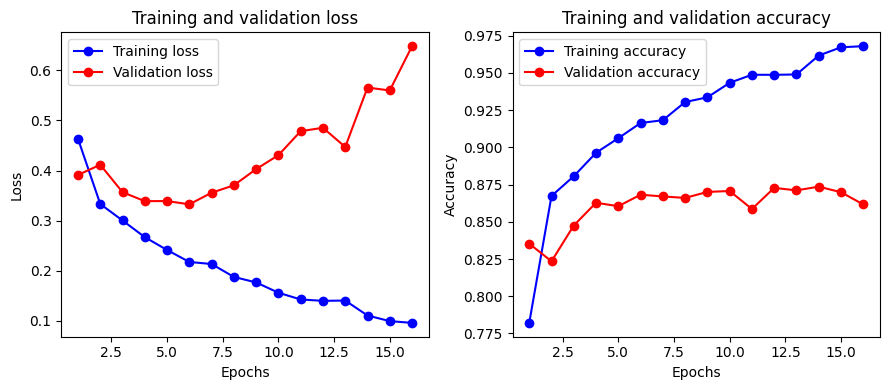

(<keras.engine.functional.Functional at 0x7f545484e370>,
 <keras.callbacks.History at 0x7f545b09bb50>)

In [ ]:
# GRU 64 - Hidden layer
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": 16,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(train_ds, test_ds, hyperparameters)

### Different learning rates

For this experiment, we tried to increase the learning rate to 0.01 and although it lead to a network with an accuracy of 0.9000 in validaton after the first epoch, the performance dropped significantly below 0.6000 for the last epochs of the training. Therefore, we do not consider the network as an improvement, since that could be just "luck" in the initialization process of the weights. 

The learning process controlled by the learning rate must guarantee convergence, which in this case is already too early. The use of higher values will only cause the localization of the network weights to local minima. 

Conversely, lower values will only delay convergence without any improvement, as demonstrated by the use of a learning rate schedule that decreases the learning rate by a factor of 0.1 every 5 epochs.


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           640000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 111s 129ms/step - loss: 0.3549 - accuracy: 0.8343 - val_loss: 0.2463 - val_accuracy: 0.9022
Epoch 2/50
782/782 [=============

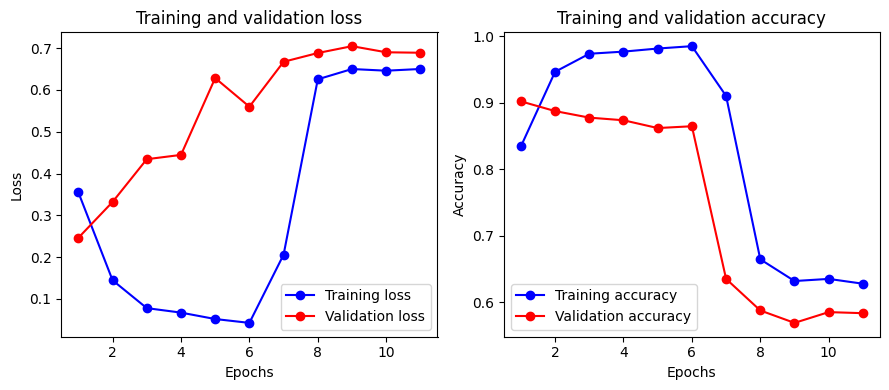

(<keras.engine.functional.Functional at 0x7f028f7edf40>,
 <keras.callbacks.History at 0x7f0228732520>)

In [ ]:
# GRU 64 - LR 
hyperparameters = {
    "epochs": 50,
    "lr": 0.01,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 32)           64000     
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 82,881
Trainable params: 82,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 67s 78ms/step - loss: 0.4724 - accuracy: 0.7635 - val_loss: 0.3837 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 2/50
782/782 [====

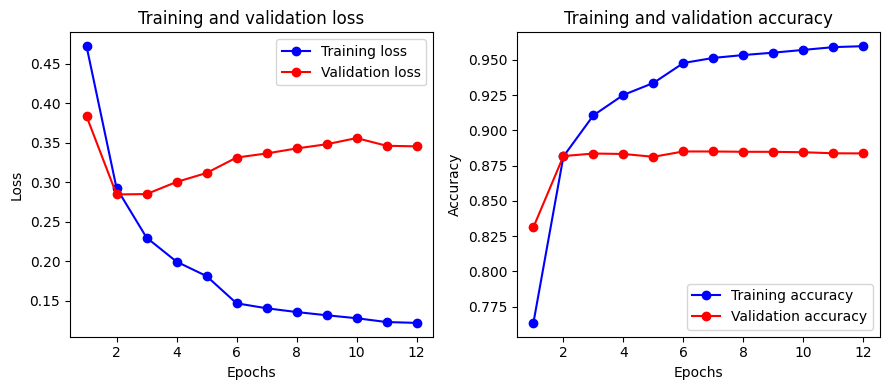

(<keras.engine.functional.Functional at 0x7f54ad720070>,
 <keras.callbacks.History at 0x7f54ad71dfd0>)

In [ ]:
# GRU 64 - LR 
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": LearningRateScheduler(lambda epoch, lr: lr * 0.1 if epoch in (5,10,15) else lr),
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

### Different Optimizer (RMSprop)

Setting a different optimizer to check if maybe updating the weights in a different way could lead for better results, in this case using RMSprop, lead to similar curves but slightly better results. We achieve the best model so far with a validation accuracy of 0.8934.

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           64000     
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 82,881
Trainable params: 82,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 59s 63ms/step - loss: 0.4709 - accuracy: 0.7614 - val_loss: 0.3613 - val_accuracy: 0.8582
Epoch 2/50
782/782 [=================

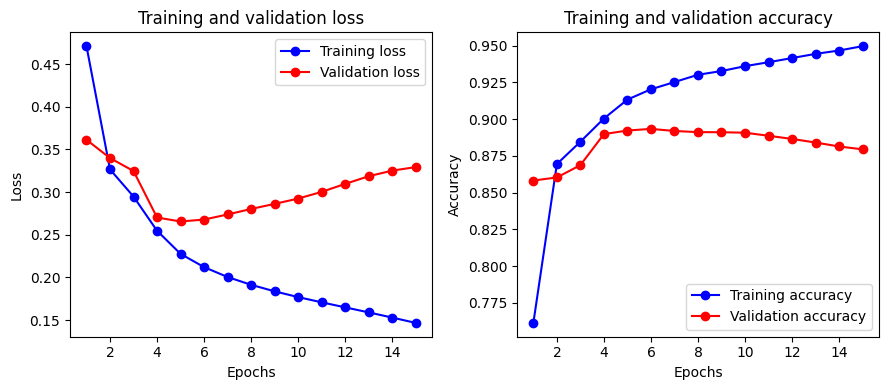

(<keras.engine.functional.Functional at 0x7f55390786d0>,
 <keras.callbacks.History at 0x7f552020f130>)

In [ ]:
# GRU 64 - RMSprop 
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

### Different vocabulary sizes
The increase of the vocabulary size allows a greater understanding of the messages since more words can be learnt. However, very large vocabularies, considering the small amount of text present, introduces overfitting behaviors in validation, reducing the capacity of inference. 

In this experiment, we obtain the best results with a vocabulary size of 20000 words, achievein again a slightly improvement with a validation accuracy of 0.8962.


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           640000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 83s 93ms/step - loss: 0.4556 - accuracy: 0.7735 - val_loss: 0.3408 - val_accuracy: 0.8632
Epoch 2/50
782/782 [===============

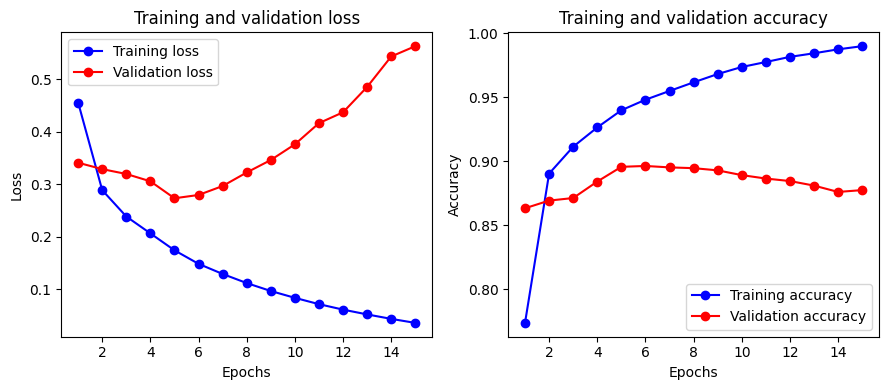

(<keras.engine.functional.Functional at 0x7fc53c147af0>,
 <keras.callbacks.History at 0x7fc531ab1520>)

In [ ]:
# GRU 64 - 20000 words (intead of 2000)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 32)           1600000   
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,618,881
Trainable params: 1,618,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 78s 94ms/step - loss: 0.4543 - accuracy: 0.7737 - val_loss: 0.3688 - val_accuracy: 0.8538
Epoch 2/50
782/782 [===========

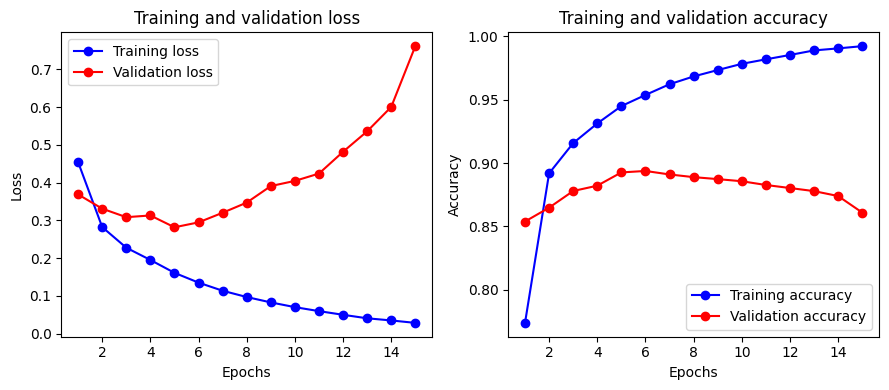

(<keras.engine.functional.Functional at 0x7fc530adc520>,
 <keras.callbacks.History at 0x7fc5317f52e0>)

In [ ]:
# GRU 64 - 50000 words (intead of 2000)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 64)           3200000   
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,276,577
Trainable params: 3,276,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=======================

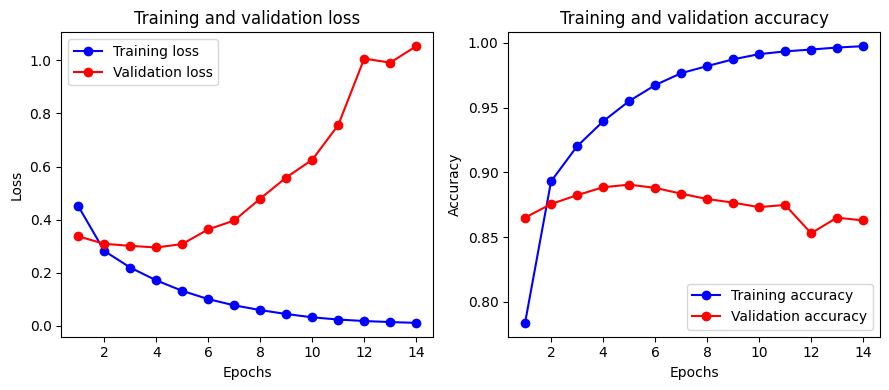

(<keras.engine.functional.Functional at 0x7fc4a629be20>,
 <keras.callbacks.History at 0x7fc53c1f68b0>)

In [ ]:
# just to ensure -> more complex network (units + embedding size)
# GRU 128 - 50000 words (intead of 2000)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 64,
    "hidden_layer": 16,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

### Different sequence lengths
A larger context should facilitate the classification because more context is taken into account. However, in this case by using as length the term `mean_seq_len + 2*std_seq_len` it is assumed to be using an already adequate length, so there is no improvement, as demonstrated by the results the results.



Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 32)           640000    
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 56s 66ms/step - loss: 0.4734 - accuracy: 0.7576 - val_loss: 0.3871 - val_accuracy: 0.8336
Epoch 2/50
782/782 [===============

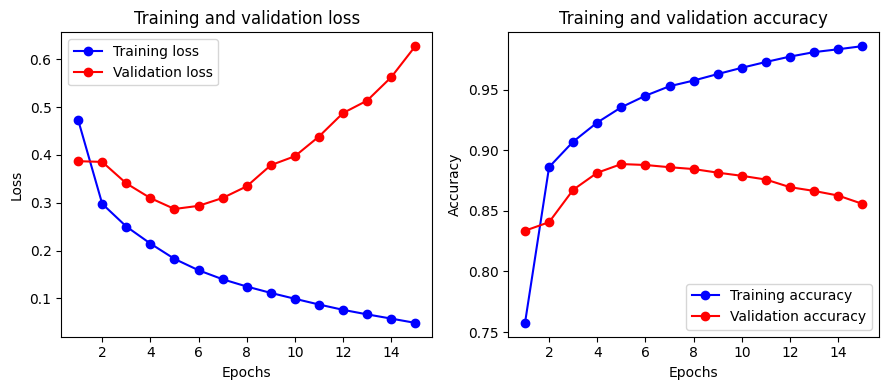

(<keras.engine.functional.Functional at 0x7fc4a6ae05b0>,
 <keras.callbacks.History at 0x7fc4a66e2c70>)

In [ ]:
# GRU 64 - lower seq size (100)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

### Bidirectional RNN
Since human reading is not strictly sequential and there is the problem of vanishing gradients, the inclusion of bidirectional networks could be useful for these non-attention-based models because we can aggregate information from two different ways of processing the information: from the start to the end and viceversa. This experiment, though, shows that for this problem is does not contributes to a better performance. In fact, an important drop down is observed in the last epoch of the training.


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 32)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              37632     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 677,761
Trainable params: 677,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 88s 99ms/step - loss: 0.3807 - accuracy: 0.8224 - val_loss:

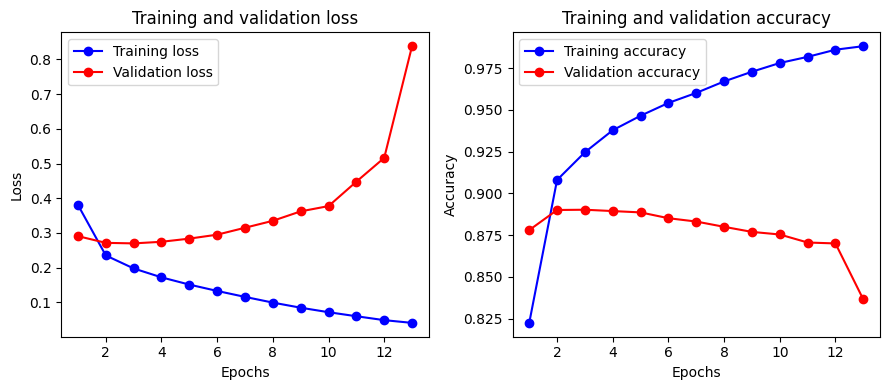

(<keras.engine.functional.Functional at 0x7fded01046a0>,
 <keras.callbacks.History at 0x7fde404d2670>)

In [ ]:
# GRU 64 - Bidirectional
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

### More complex networks with optimal parameters
- Next, multiple models will be trained that will try to integrate and improve the results that have been fruitful so far.
- First of all, the complexity of the model will be increased since a larger amount of vocabulary is being used.
- In addition, we will look to see if this increase in the vocabulary could give synergies with a larger embedding size, because when dealing with more words, there may be the need to use more complex contexts. It should be noted that the increase in embedding size will be accompanied by a more complex recurrent network.
- The only approach that has given good results has been the first one (slightly increasing the complexity of the model with the increase of the lexicon).
- This way, we have obtained a new best result in validation: 0.8980 of accuracy with a GRU with 128 neurons.

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_9 (GRU)                 (None, 128)               62208     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 702,337
Trainable params: 702,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 61s 72ms/step - loss: 0.4692 - accuracy: 0.7681 - val_loss: 0.3346 - val_accuracy: 0.8682
Epoch 2/50
782/782 [===============

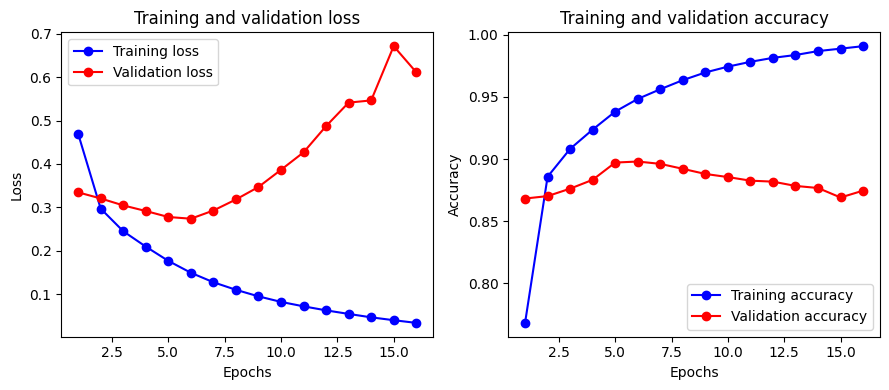

(<keras.engine.functional.Functional at 0x7fc48bf622b0>,
 <keras.callbacks.History at 0x7fc48be41220>)

In [ ]:
# GRU 128
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_5 (GRU)                 (None, 166, 32)           6336      
                                                                 
 gru_6 (GRU)                 (None, 32)                6336      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 652,705
Trainable params: 652,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

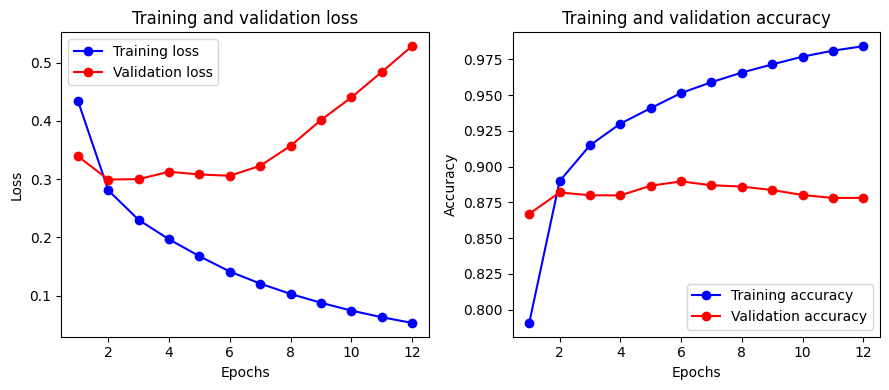

(<keras.engine.functional.Functional at 0x7fc4a53a37c0>,
 <keras.callbacks.History at 0x7fc4a4acc4f0>)

In [ ]:
# GRU 32,32 
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [32,32],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 166, 64)           1280000   
                                                                 
 gru_7 (GRU)                 (None, 166, 64)           24960     
                                                                 
 gru_8 (GRU)                 (None, 64)                24960     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,985
Trainable params: 1,329,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [=======================

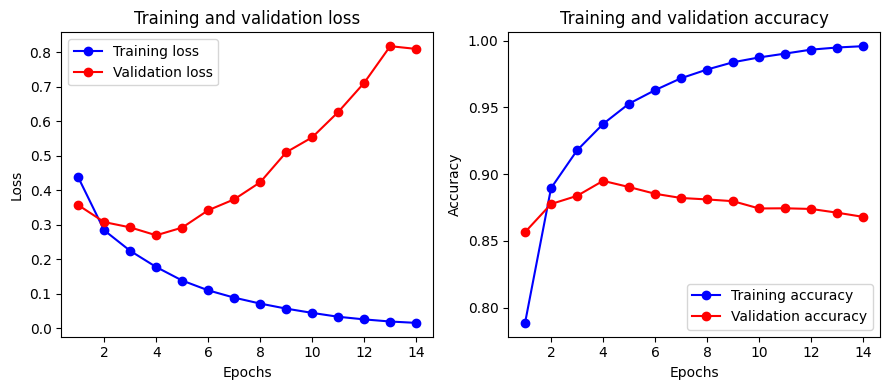

(<keras.engine.functional.Functional at 0x7fc48ae9cb80>,
 <keras.callbacks.History at 0x7fc48aa903a0>)

In [ ]:
# GRU 64,64 - larger embedding (64)
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64,64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

## Overfitting mitigation

So far, we were able to reach almost 0.9000 of accuracy in validation, but we observe that in the training set the accuracy can reach almost 1.000. 

Given the best architectures found, we will try now to reduce the performance difference between the training set and the validation set to reduce overtraining by applying regularization techniques.

In essence, we will start from the architectures with the best **accuracies** in validation, as well as those with the best error in training (more room for improvement). The most promising architectures are:

- Best validation accuracy:
  - GRU 64: 0.8962
  - GRU 128: 0.8972 (less stable) (higger train acc: 0.9909).
  
- Best train accuracy:
  - GRU 64,64 embedding 64: 0.9958

Regarding the proposed techniques, we will essentially use **dropout** and **weight regularization**. Techniques such as data augmentation have not been taken into account, as more data are available but have been consciously discarded. As for **batch normalization**, this technique is not used with this type of recurrent networks (https://arxiv.org/abs/1510.01378).

It should be noted that, in contrast to part 1 of this practice, a drastic overfitting can be seen in all the execution graphs, with the application of these techniques being more promising for the improvement of results.

### Dropout

- Random deactivation of neurons in training will favor the elimination of coadaptation by improving inference ability.
- Dropout is included in the recurrent unit itself, in its recurrent connections and in the dense layer.
- First different experiments are run to find the best dropout probability values and then the best configuration is run directly with other models.
- Best result in validation: 128 GRU, 0.9018


Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

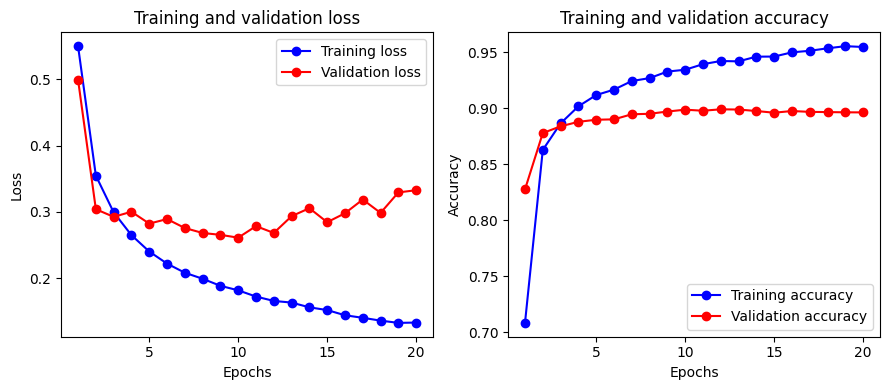

(<keras.engine.functional.Functional at 0x7f0084127af0>,
 <keras.callbacks.History at 0x7f00840c00d0>)

In [ ]:
# GRU 64 - 20000 words - dropout 
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.6,0.6,0.6),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

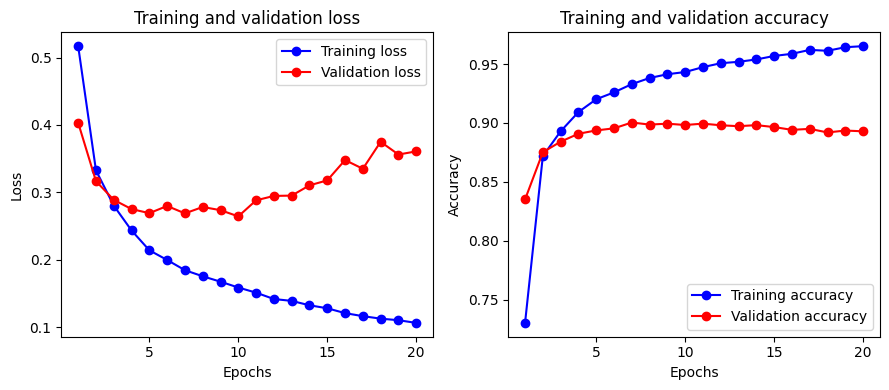

(<keras.engine.functional.Functional at 0x7f0075ab9be0>,
 <keras.callbacks.History at 0x7f0075acca90>)

In [ ]:
# GRU 64 - 20000 words - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.5,0.5,0.5),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_4 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

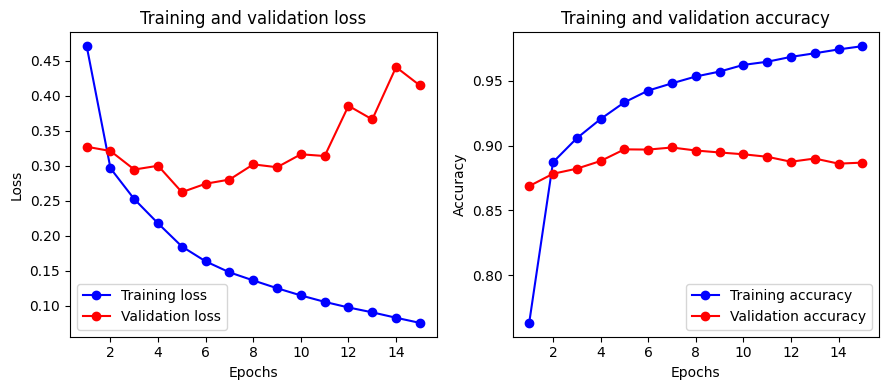

(<keras.engine.functional.Functional at 0x7f1438342610>,
 <keras.callbacks.History at 0x7f143829a100>)

In [ ]:
# GRU 64 - 20000 words - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.2,0.2,0.2),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_10 (GRU)                (None, 64)                18816     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 658,881
Trainable params: 658,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

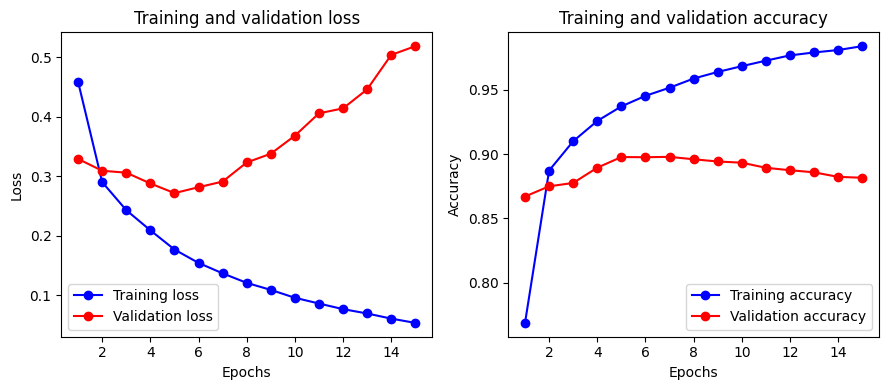

(<keras.engine.functional.Functional at 0x7fc482f54910>,
 <keras.callbacks.History at 0x7fc482e6c220>)

In [ ]:
# GRU 64 - 20000 words - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.1,0.1,0.1),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 32)           640000    
                                                                 
 gru_2 (GRU)                 (None, 128)               62208     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 702,337
Trainable params: 702,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [===========================

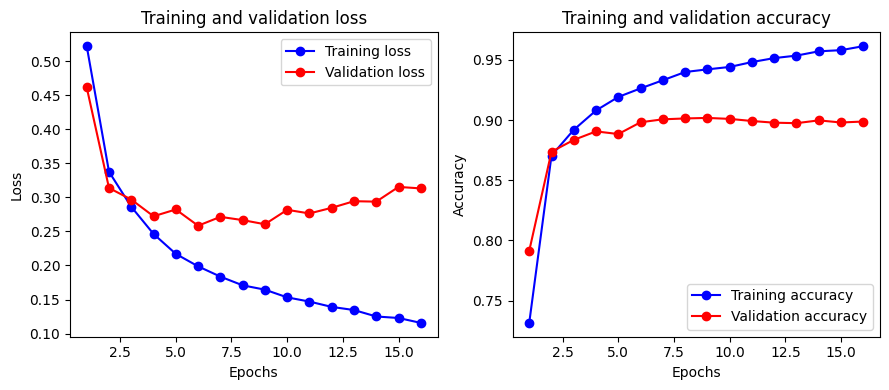

(<keras.engine.functional.Functional at 0x7f01107c0ca0>,
 <keras.callbacks.History at 0x7f0076f783a0>)

In [ ]:
# GRU 128 - 20000 words - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.5,0.5,0.5),
    "regularization": (0.,0.),
    "embedding_size": 32,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

In [ ]:
# GRU 64,64 - 20000 words - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64,64],
    "dropout": (0.5,0.5,0.5),
    "regularization": (0.,0.),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 64)           1280000   
                                                                 
 gru_3 (GRU)                 (None, 166, 64)           24960     
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,985
Trainable params: 1,329,985
N

### Weight Regularization
- The terms L1 and L2 will be applied to the error in such a way as to avoid overtraining.
- No improvement observed.



Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 64)           1280000   
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 243s 304ms/step - loss: 0.4743 - accuracy: 0.7780 - val_loss: 0.4163 - val_accuracy: 0.8512
Epoch 2/50
782/782 [=========

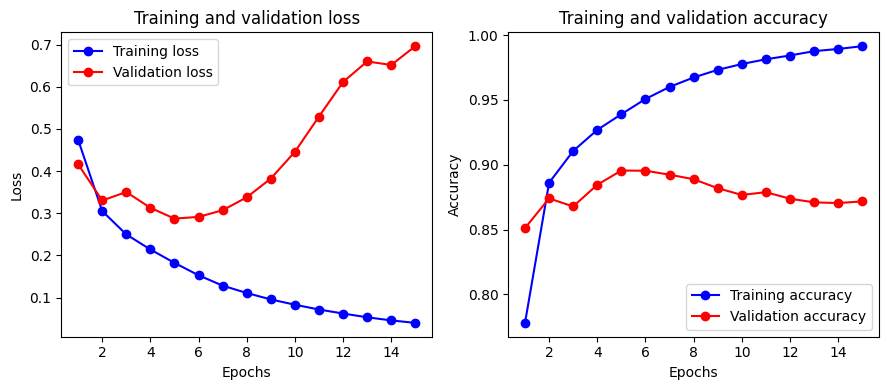

(<keras.engine.functional.Functional at 0x7f98d76acee0>,
 <keras.callbacks.History at 0x7f98d73bea00>)

In [ ]:
# GRU 128 - 20000 words - WR
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (1e-5,1e-4),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding (Embedding)       (None, 166, 64)           1280000   
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 82s 94ms/step - loss: 0.7704 - accuracy: 0.5249 - val_loss: 0.7047 - val_accuracy: 0.5137
Epoch 2/50
782/782 [===========

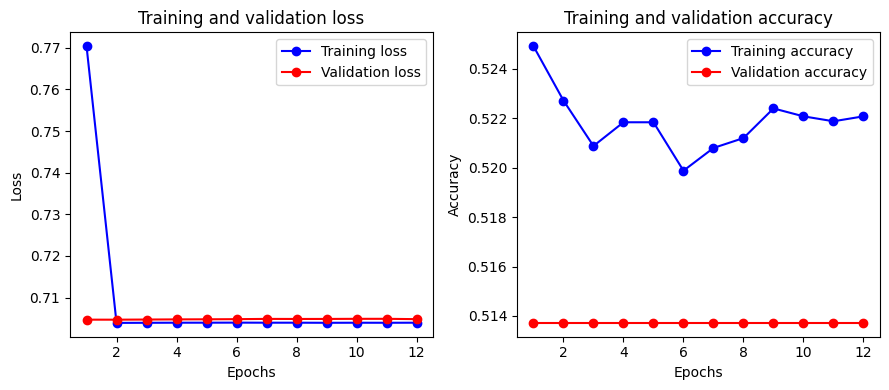

(<keras.engine.functional.Functional at 0x7fb3918fd040>,
 <keras.callbacks.History at 0x7fb37c24eb50>)

In [ ]:
# GRU 128 - 20000 words - WR
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.001,0.001),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

Model: "amazon_review"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 166)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 166, 64)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 62s 72ms/step - loss: 0.5051 - accuracy: 0.7716 - val_loss: 0.3494 - val_accuracy: 0.8690
Epoch 2/50
782/782 [===========

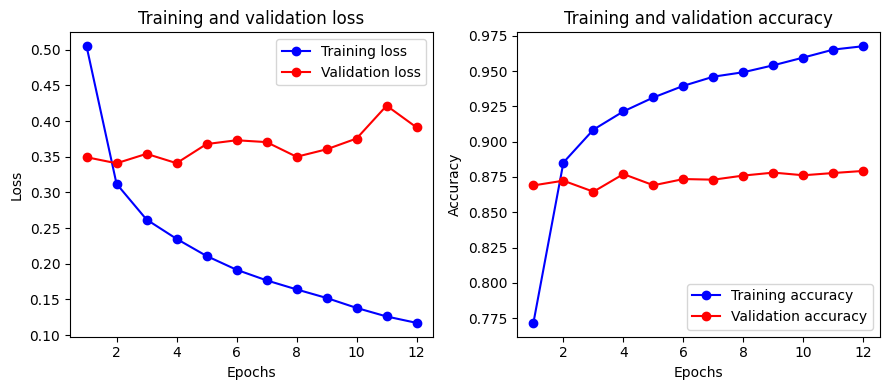

(<keras.engine.functional.Functional at 0x7fb30eebbb20>,
 <keras.callbacks.History at 0x7fb30ee79d60>)

In [ ]:
# GRU 128 - 20000 words - WR
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.0001,0.0),
    "embedding_size": 64,
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}

execute_pipeline(train_ds, test_ds, hyperparameters)

# 4. Results

---

As it has been observed in the executions, we have started exploring simple models and architectures, looking for the best configurations and integrating improvements gradually.

For the initial contact, it has been observed that GRU has empirically demonstrated its superior performance to SimpleRNN and LSTM, the difference with the latter being more subtle. While SimpleRNNs experimented a lot of variance during the training, LSTMs and GRUs showed much smoother curves, being the latter the most robust probably due to the its simplicity with respect to LSTMs. Also, SimpleRNNs does not handle complexity well, since the best versions are the ones with 16 neurons, experimenting notable drop downs with more neurons. On the other hand, LSTMs and GRUs show their best with 128 or 64 neurons, respectively.

In terms of validation accuracy for the best initial models, the values obtained are 0.8785, 0.8442 and 0.8875 for the 128 LSTMs, 16 simple RNNs and 64 GRUs, respectively. Note that this best model will be the one with only one recurrent unit, being worsened with the increase of neurons in it or with the increase of stacked recurrent units. Also, in all the trainings performed, there is a very fast convergence in only a couple of epochs, so that in next iterations the loss in train is reduced in favor of overfitting the model and losing inference capabilities.

Having an approximate idea of the complexity of the problem to be solved, we continue to include elements that either improve its results or mitigate or stabilize the overlearning of the network. Thus, given its obvious better performance, the models will now focus only on GRUs, specifically single-cell GRUs, removing exceptions to validate that a simple network is better (in terms of results).

Starting with the changes, different embedding sizes, a more complex classifier, different learning rates, different optimizers, different lexicon sizes as well as sequence sizes and finally bidirectional recurrent networks have been tested. Since so many different things have been tested, for the sake of brevity we will only focus on those that have improved the results. These changes will be:

- The use of the RMSprop optimizer, achieving a validation accuracy of 0.8934. However, as an observation, the accuracy in train obtained is somewhat penalized (0.9496 against the 0.9610 obtained previously).

- The increase in vocabulary size also shows a clear improvement when classifying reviews. This increase from 2000 to 20000 together with the change of optimizer allows to obtain a validation accuracy of 0.8962. It should be noted that despite these improvements there is still a rapid convergence and subsequent overtraining.

After empirically testing the proposed improvements, we proceed to use more complex architectures to verify if there is an improvement. The improvement is really subtle, but with twice the number of neurons in the recurrent cell (128) a validation accuracy of 0.8980 is achieved. The use of more complex models does not provide any improvement. 

Finally, to try to mitigate overtraining, 2 techniques have been applied: dropout and weight regularization. Only the first one has shown good results thanks to the mitigation of neuron coadaptation. The best performing dropout rates are considerably high, being 0.5 and the results obtained are of 0.9018 accuracy in the validation set. 

The dropout manages to maintain learning until round 8, being by far the model that remains learning the most rounds. Additionally, as a positive aspect, the stability in later rounds should be appreciated, because although it decreases due to overtraining, the decrease is negligible.




# 5. Conclusions


---

Unlike the first part of this practice, in this problem the absence of a large volume of data is evident, where the models achieve early convergences due iterations of a small amount of data. The use of embeddings should be kept in mind, so they need a large amount of representative data for their generalization to be adequate. Thus, by iterating over only 25,000 samples, the need for more information will become apparent in order to obtain a more optimal generalization.

In relation to the results, it is considered that with 90% accuracy in the validation set the model is able to perform the task for which it was trained more than adequately.

Therefore, for future work, we would either seek to use a larger volume of data to train these low-level representations of the words, or even the use of  pre-trained embeddings that only need to update certain traces of the meaning of the words oriented to the problem to be solved.